In [7]:
from PIL import Image
import sys, os

sys.path.append(os.path.abspath(".."))

In [10]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch.nn as nn
import numpy as np
import math

from src.domain.models import load_processor, load_model

In [11]:
model = load_model()
processor = load_processor()

Loading model from: Ateeqq/ai-vs-human-image-detector
Model loaded successfully.
Loading processor from: Ateeqq/ai-vs-human-image-detector
Processor loaded successfully.


In [12]:
# Create a wrapper model that returns only logits (tensors) instead of ModelOutput
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model
        self.vision_model = model.vision_model
        
    def forward(self, x):
        outputs = self.model(pixel_values=x)
        return outputs.logits

def get_model_config(model):
    config_dict = {}

    # Get themodel configuratioin to determine the correct grid size
    config = model.config.vision_config
    image_size = config.image_size
    patch_size = config.patch_size
    num_patches = (image_size // patch_size) ** 2
    print(f"Image size: {image_size}, Patch size: {patch_size}, Num patches: {num_patches}")

    config_dict["image_size"] = image_size
    config_dict["patch_size"] = patch_size
    config_dict["num_patches"] = num_patches

    return config_dict
    
# Custom reshape transform for Siglip model
def siglip_reshape_transform(tensor, height=None, width=None):
    """
    Siglip models don't use a CLS token, so we reshape all patches
    """
    batch_size = tensor.size(0)
    num_tokens = tensor.size(1)
    channels = tensor.size(2)
    
    # Calculate height and width from number of tokens
    h = w = int(math.sqrt(num_tokens))
    
    # Reshape: (batch, num_patches, channels) -> (batch, height, width, channels)
    result = tensor.reshape(batch_size, h, w, channels)
    
    # Transpose to (batch, channels, height, width) for CNN format
    result = result.permute(0, 3, 1, 2)
    
    return result

def get_visualize_gradcam(model, target_layers, targets, input_tensor, image, image_size):
    # Construct the CAM object once, and then re-use it on many images.
    # Use custom reshape_transform for Siglip models
    with GradCAM(model=model, 
                target_layers=target_layers,
                reshape_transform=siglip_reshape_transform) as cam:
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        # In this example grayscale_cam has only one image in the batch:
        grayscale_cam = grayscale_cam[0, :]
        
        # Convert image to numpy array and normalize to [0, 1]
        image_np = np.array(image.resize((image_size, image_size))) / 255.0
        
        visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
        # You can also get the model outputs without having to redo inference
        model_outputs = cam.outputs

    return visualization, model_outputs
    

In [13]:
wrapped_model = ModelWrapper(model)
wrapped_model

ModelWrapper(
  (model): SiglipForImageClassification(
    (vision_model): SiglipVisionTransformer(
      (embeddings): SiglipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
        (position_embedding): Embedding(196, 768)
      )
      (encoder): SiglipEncoder(
        (layers): ModuleList(
          (0-11): 12 x SiglipEncoderLayer(
            (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (self_attn): SiglipAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): SiglipMLP(
              (activation_fn): GELUTanh

In [14]:
def main(image_path, target_class=0):
    image = Image.open(image_path).convert("RGB")

    # set model and target layers
    wrapped_model = ModelWrapper(model)
    wrapped_model.eval()

    target_layers = [wrapped_model.vision_model.encoder.layers[-1].layer_norm1]
    input_tensor = processor(image, return_tensors="pt")["pixel_values"].to(model.device)

    targets = [ClassifierOutputTarget(target_class)]  # Change to 0 or 1 depending on which class you want to visualize

    config_dict = get_model_config(model)
    image_size = config_dict["image_size"]

    # get visualization and model outputs
    visualization, model_outputs = get_visualize_gradcam(wrapped_model, target_layers, targets, input_tensor, image, image_size)

    return visualization, model_outputs
    

In [15]:
wrapped_model.vision_model.post_layernorm

LayerNorm((768,), eps=1e-06, elementwise_affine=True)

# image 1

In [16]:
image_path = "/Users/ych/work/hoonyandu/gen-image-detector/image/image1.jpg"
target_class = 0

visualization, model_outputs = main(image_path, target_class)

Image size: 224, Patch size: 16, Num patches: 196


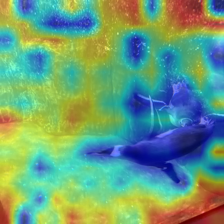

In [17]:
tmp_image = Image.fromarray(visualization)
tmp_image

Image size: 224, Patch size: 16, Num patches: 196


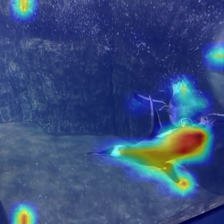

In [18]:
image_path = "/Users/ych/work/hoonyandu/gen-image-detector/image/image1.jpg"
target_class = 1

visualization, model_outputs = main(image_path, target_class)
tmp_image = Image.fromarray(visualization)
tmp_image

In [19]:
model.config.id2label

{0: 'ai', 1: 'hum'}

In [20]:
model_outputs

tensor([[-2.3130,  4.9403]], grad_fn=<AddmmBackward0>)

# image 2

Image size: 224, Patch size: 16, Num patches: 196


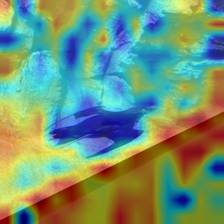

In [21]:
image_path = "/Users/ych/work/hoonyandu/gen-image-detector/image/image2.jpg"
target_class = 0

visualization, model_outputs = main(image_path, target_class)
tmp_image = Image.fromarray(visualization)
tmp_image

Image size: 224, Patch size: 16, Num patches: 196


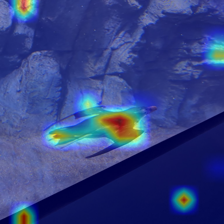

In [22]:
image_path = "/Users/ych/work/hoonyandu/gen-image-detector/image/image2.jpg"
target_class = 1

visualization, model_outputs = main(image_path, target_class)
tmp_image = Image.fromarray(visualization)
tmp_image

# image 3

Image size: 224, Patch size: 16, Num patches: 196


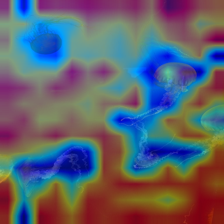

In [23]:
image_path = "/Users/ych/work/hoonyandu/gen-image-detector/image/image3.jpg"
target_class = 0

visualization, model_outputs = main(image_path, target_class)
tmp_image = Image.fromarray(visualization)
tmp_image

Image size: 224, Patch size: 16, Num patches: 196


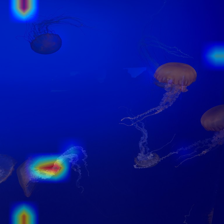

In [24]:
image_path = "/Users/ych/work/hoonyandu/gen-image-detector/image/image3.jpg"
target_class = 1

visualization, model_outputs = main(image_path, target_class)
tmp_image = Image.fromarray(visualization)
tmp_image

In [25]:
model_outputs


tensor([[-2.4694,  5.7460]], grad_fn=<AddmmBackward0>)

# image 4

Image size: 224, Patch size: 16, Num patches: 196


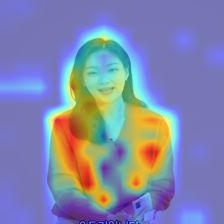

In [26]:
image_path = "/Users/ych/work/hoonyandu/gen-image-detector/image/image4.png"
target_class = 0

visualization, model_outputs = main(image_path, target_class)
tmp_image = Image.fromarray(visualization)
tmp_image

Image size: 224, Patch size: 16, Num patches: 196


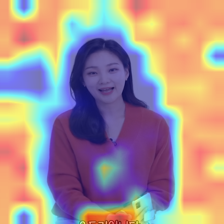

In [27]:
image_path = "/Users/ych/work/hoonyandu/gen-image-detector/image/image4.png"
target_class = 1

visualization, model_outputs = main(image_path, target_class)
tmp_image = Image.fromarray(visualization)
tmp_image

In [28]:
model_outputs

tensor([[ 6.0378, -3.3723]], grad_fn=<AddmmBackward0>)

# image 5

Image size: 224, Patch size: 16, Num patches: 196


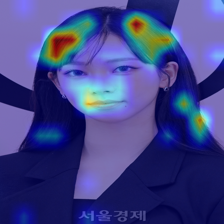

In [29]:
image_path = "/Users/ych/work/hoonyandu/gen-image-detector/image/image5.png"
target_class = 0

visualization, model_outputs = main(image_path, target_class)
tmp_image = Image.fromarray(visualization)
tmp_image

Image size: 224, Patch size: 16, Num patches: 196


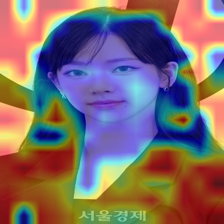

In [30]:
image_path = "/Users/ych/work/hoonyandu/gen-image-detector/image/image5.png"
target_class = 1

visualization, model_outputs = main(image_path, target_class)
tmp_image = Image.fromarray(visualization)
tmp_image

In [31]:
model.config.id2label

{0: 'ai', 1: 'hum'}

In [32]:
model_outputs

tensor([[ 6.4455, -3.8825]], grad_fn=<AddmmBackward0>)

# image 6

Image size: 224, Patch size: 16, Num patches: 196


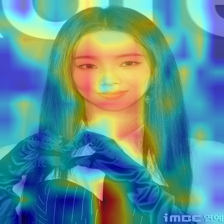

In [33]:
image_path = "/Users/ych/work/hoonyandu/gen-image-detector/image/image6.png"
target_class = 0

visualization, model_outputs = main(image_path, target_class)
tmp_image = Image.fromarray(visualization)
tmp_image

Image size: 224, Patch size: 16, Num patches: 196


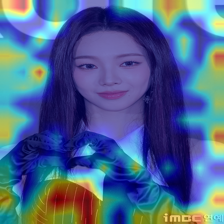

In [34]:
image_path = "/Users/ych/work/hoonyandu/gen-image-detector/image/image6.png"
target_class = 1

visualization, model_outputs = main(image_path, target_class)
tmp_image = Image.fromarray(visualization)
tmp_image

In [35]:
model_outputs

tensor([[ 5.5267, -2.5085]], grad_fn=<AddmmBackward0>)